# Data Preparation
- author: Hamid Ali Syed
- email: hamidsyed37[at]gmail[dot]com

In [1]:
import warnings
warnings.filterwarnings("ignore")
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

## Data collection
### Let's do some Web Scrapping
Let's do some Web Scrapping. We can scrap the radar site information from the website of the Indian Meteorological Department (IMD) and extract location information from the HTML using BeautifulSoup. Then, we can clean and transform the extracted data into a Pandas DataFrame, with longitude and latitude coordinates for each location. Finally, we can plot the DataFrame as a scatter plot using longitude and latitude as x and y axes, respectively.

title   latitude  longitude
2               Bhopal  23.259900  77.412600
3             Agartala  23.831500  91.286800
4                Delhi  28.563200  77.191200
5                 Bhuj  23.242000  69.666900
6              Chennai  13.082700  80.270700
7               Panaji  15.490900  73.827800
8             Gopalpur  19.264700  84.862000
9            Hyderabad  17.385000  78.486700
10              Jaipur  26.912400  75.787300
11             Kolkata  22.572600  88.363900
12               Kochi   9.931200  76.267300
13            Karaikal  10.925400  79.838000
14             Lucknow  26.846700  80.946200
15       Machilipatnam  16.190500  81.136200
16              Mumbai  19.076000  72.877700
17              Nagpur  21.145800  79.088200
18               Sohra  25.270200  91.732300
19             Patiala  30.339800  76.386900
20               Patna  25.594100  85.137600
21            Srinagar  34.083656  74.797371
22               Jammu  32.926600  74.857000
23  Thiruvananthapuram   8.524100  76.936600
24       Visakhapatnam  17.686800  83.218500
25           Mohanbari  27.472800  94.912000
26             Paradip  20.316600  86.611400
27         Sriharikota  13.725900  80.226600
28                 Jot  32.486800  76.059300
29              Murari  30.789800  78.917850
30               Palam  28.590100  77.088800
31          Mukteshwar  29.460400  79.655800
32            Veravali  19.734300  72.876300
33               Kufri  31.097800  77.267800
34          Surkandaji  30.411400  78.288500

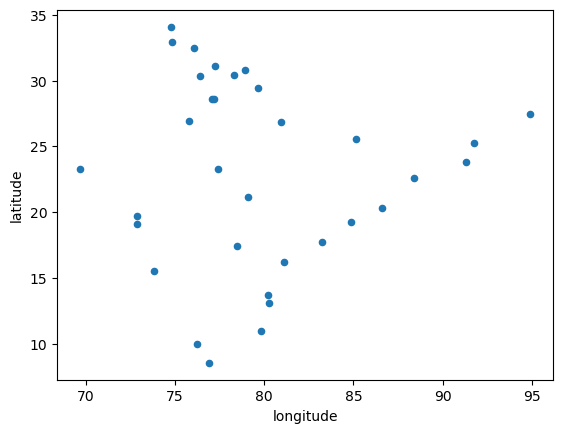

In [2]:
url = "https://mausam.imd.gov.in/imd_latest/contents/index_radar.php"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

# extract the relevant part of the HTML
images_html = soup.find_all("script")[-2].text.split("images: [")[0].split("],\n")[0]

# split the HTML into individual locations and extract the relevant information
locations = []
for image in soup.find_all("script")[-2].text.split("images: [")[0].split("],\n")[0].split("{")[1:]:
    location_dict = {}
    for line in image.split("\n"):
        if "title" in line:
            location_dict["title"] = line.split(": ")[-1].strip(',')
        elif "latitude" in line:
            location_dict["latitude"] = line.split(": ")[-1].strip(',')
        elif "longitude" in line:
            location_dict["longitude"] = line.split(": ")[-1].strip(',')
    locations.append(location_dict)

# create a DataFrame from the list of dictionaries
df = pd.DataFrame(locations)
df = df.dropna()
df['title'] = df['title'].str.strip(", ").str.strip('"')
df['longitude'] = df['longitude'].str.strip(", ").str.strip('longitude":')
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['title'].replace("Goa", "Panaji", inplace=True)
df.plot(kind='scatter', x='longitude', y='latitude')
df

We have procured the name, lat, & lon info of all the radar sites and is saved in `df`. Now, let's search for their frequency bands. I have found a webpage on the IMD website that contains this information for most of the radars. Let's make a request to a URL and create a BeautifulSoup object to parse the HTML content. It will find a table on the page, then we can extract the headers and rows of the table, and create a Pandas DataFrame `df2` from the table data.
<p>Drop the "S No" column, clean up the "Type of DWR" and "DWR Station" columns by removing certain text, and replace some values in the "DWR Station" column.</p>

In [3]:
# make a request to the URL
url = "https://mausam.imd.gov.in/imd_latest/contents/imd-dwr-network.php"
response = requests.get(url)

# create a BeautifulSoup object
soup = BeautifulSoup(response.content, "html.parser")

# find the table on the page
table = soup.find("table")

# extract the table headers
headers = [header.text.strip() for header in table.find_all("th")]

# extract the table rows
rows = []
for row in table.find_all("tr")[1:]:
    cells = [cell.text.strip() for cell in row.find_all("td")]
    rows.append(cells)

# create a DataFrame from the table data
df2 = pd.DataFrame(rows, columns=headers)
df2.drop("S No", axis=1, inplace=True)
df2['Type of DWR'] = df2['Type of DWR'].str.replace(' - Band', '')
df2['DWR Station'].replace('Delhi (Palam)', 'Palam', inplace=True)
df2['DWR Station'] = df2['DWR Station'].str.replace('\(ISRO\)', '').str.replace('\(Mausam Bhawan\)', 
                                                                                '').str.strip()
df2

DWR Station              State Type of DWR
0             Agartala            Tripura           S
1               Bhopal     Madhya Pradesh           S
2                 Bhuj            Gujarat           S
3              Chennai         Tamil Nadu           S
4         Cherrapunjee          Meghalaya           S
5                Palam              Delhi           S
6               Panaji                Goa           S
7             Gopalpur             Odisha           S
8            Hyderabad          Telangana           S
9               Jaipur          Rajasthan           C
10             Kolkata        West Bengal           S
11               Kochi             Kerala           S
12            Karaikal         Tamil Nadu           S
13             Lucknow      Uttar Pradesh           S
14       Machilipatnam     Andhra Pradesh           S
15           Mohanbari              Assam           S
16              Mumbai        Maharashtra           S
17              Nagpur        Maharashtra           S
18           New Delhi              Delhi           C
19             Paradip             Odisha           S
20             Patiala             Punjab           S
21               Patna              Bihar           S
22            Srinagar  Jammu and Kashmir           X
23  Thiruvananthapuram             Kerala           C
24       Visakhapatnam     Andhra Pradesh           S

Let's merge two previously created Pandas DataFrames, `df` and `df2`, using the "title" and "DWR Station" columns as keys, respectively. It will drop the "DWR Station" column, rename the "Type of DWR" column as "Band", and replace some values in the "title" column. The code will count the number of NaN values in the "Band" column, print this count, and return the resulting merged DataFrame.

In [4]:
merged_df = df.merge(df2, left_on='title', right_on='DWR Station', how='left')
merged_df = merged_df.drop(columns=['DWR Station'])
merged_df = merged_df.rename(columns={'Type of DWR': 'Band'})
merged_df['title'].replace("Goa", "Panaji", inplace=True)
num_nans = merged_df['Band'].isna().sum()
print(num_nans)
merged_df

10


title   latitude  longitude              State Band
0               Bhopal  23.259900  77.412600     Madhya Pradesh    S
1             Agartala  23.831500  91.286800            Tripura    S
2                Delhi  28.563200  77.191200                NaN  NaN
3                 Bhuj  23.242000  69.666900            Gujarat    S
4              Chennai  13.082700  80.270700         Tamil Nadu    S
5               Panaji  15.490900  73.827800                Goa    S
6             Gopalpur  19.264700  84.862000             Odisha    S
7            Hyderabad  17.385000  78.486700          Telangana    S
8               Jaipur  26.912400  75.787300          Rajasthan    C
9              Kolkata  22.572600  88.363900        West Bengal    S
10               Kochi   9.931200  76.267300             Kerala    S
11            Karaikal  10.925400  79.838000         Tamil Nadu    S
12             Lucknow  26.846700  80.946200      Uttar Pradesh    S
13       Machilipatnam  16.190500  81.136200     Andhra Pradesh    S
14              Mumbai  19.076000  72.877700        Maharashtra    S
15              Nagpur  21.145800  79.088200        Maharashtra    S
16               Sohra  25.270200  91.732300                NaN  NaN
17             Patiala  30.339800  76.386900             Punjab    S
18               Patna  25.594100  85.137600              Bihar    S
19            Srinagar  34.083656  74.797371  Jammu and Kashmir    X
20               Jammu  32.926600  74.857000                NaN  NaN
21  Thiruvananthapuram   8.524100  76.936600             Kerala    C
22       Visakhapatnam  17.686800  83.218500     Andhra Pradesh    S
23           Mohanbari  27.472800  94.912000              Assam    S
24             Paradip  20.316600  86.611400             Odisha    S
25         Sriharikota  13.725900  80.226600                NaN  NaN
26                 Jot  32.486800  76.059300                NaN  NaN
27              Murari  30.789800  78.917850                NaN  NaN
28               Palam  28.590100  77.088800              Delhi    S
29          Mukteshwar  29.460400  79.655800                NaN  NaN
30            Veravali  19.734300  72.876300                NaN  NaN
31               Kufri  31.097800  77.267800                NaN  NaN
32          Surkandaji  30.411400  78.288500                NaN  NaN

Since there are NaN values in the "State" column, we can find the state names using lat and lon info. We can use the Cartopy library to create a map of India with state boundaries and labels. Then we will create a pandas DataFrame `gdf` containing the latitude and longitude coordinates of each state and union territory, and try to map the names of these places in the `merged_df`

In [5]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd
# Load the Natural Earth dataset
states_shp = shpreader.natural_earth(resolution='10m',
                                     category='cultural',
                                     name='admin_1_states_provinces')

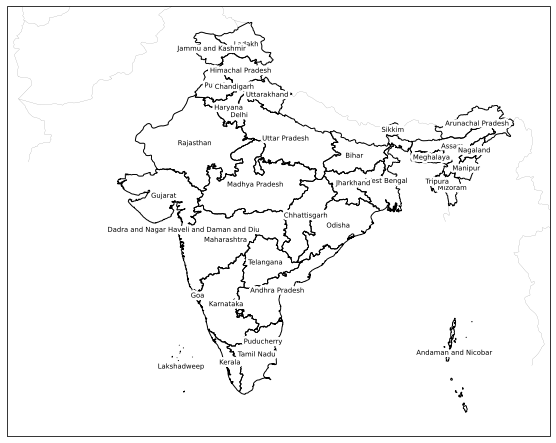

In [6]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as feat

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

# get the data
fn = shpreader.natural_earth(
    resolution='10m', category='cultural', 
    name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
states = [x for x in reader.records() if x.attributes["admin"] == "India"]
states_geom = feat.ShapelyFeature([x.geometry for x in states], ccrs.PlateCarree())

data_proj = ccrs.PlateCarree()

# create the plot
fig, ax = plt.subplots(
    figsize=(10,10), dpi=70, facecolor="w",
    subplot_kw=dict(projection=data_proj),
)

ax.add_feature(feat.BORDERS, color="k", lw=0.1)
# ax.add_feature(feat.COASTLINE, color="k", lw=0.2)
ax.set_extent([60, 100, 5, 35], crs=ccrs.Geodetic())

ax.add_feature(states_geom, facecolor="none", edgecolor="k")

# # add the names
for state in states:
    lon = state.geometry.centroid.x
    lat = state.geometry.centroid.y
    name = state.attributes["name"] 
    
    ax.text(
        lon, lat, name, size=7, transform=data_proj, ha="center", va="center",
        path_effects=[PathEffects.withStroke(linewidth=5, foreground="w")]
    )

In [7]:
locs = {}
for state in states:
    lon = state.geometry.centroid.x
    lat = state.geometry.centroid.y
    name = state.attributes["name"]
    locs[name] = {"lat": lat, "lon": lon}
gdf = pd.DataFrame(locs, ).T
gdf.reset_index(inplace=True)
gdf = gdf.rename({'index':'state'}, axis=1)
gdf.index = np.arange(1, len(gdf) + 1)

In [8]:
gdf

state        lat        lon
1                                     Ladakh  33.885957  77.634965
2                          Arunachal Pradesh  28.035900  94.660514
3                                     Sikkim  27.572023  88.448173
4                                West Bengal  23.805249  87.972564
5                                      Assam  26.356938  92.831287
6                                Uttarakhand  30.163721  79.196121
7                                   Nagaland  26.059820  94.448403
8                                    Manipur  24.730388  93.861591
9                                    Mizoram  23.292031  92.819139
10                                   Tripura  23.754753  91.728537
11                                 Meghalaya  25.536122  91.287036
12                                    Punjab  30.848293  75.404354
13                                 Rajasthan  26.592714  73.834251
14                                   Gujarat  22.712829  71.558165
15                          Himachal Pradesh  31.936310  77.220849
16                         Jammu and Kashmir  33.557813  75.079701
17                                     Bihar  25.662102  85.604230
18                             Uttar Pradesh  26.934734  80.541922
19                            Andhra Pradesh  15.721672  79.924211
20                                    Odisha  20.517113  84.414536
21  Dadra and Nagar Haveli and Daman and Diu  20.199380  72.992494
22                               Maharashtra  19.460457  76.111348
23                                       Goa  15.352195  74.045828
24                                 Karnataka  14.719826  76.155168
25                                    Kerala  10.423815  76.424882
26                                Puducherry  11.960162  78.885684
27                                Tamil Nadu  11.014705  78.402304
28                               Lakshadweep  10.120942  72.827601
29                       Andaman and Nicobar  11.133776  92.975529
30                                 Jharkhand  23.642010  85.533387
31                                     Delhi  28.660865  77.107946
32                                Chandigarh  30.743535  76.768380
33                            Madhya Pradesh  23.539092  78.292780
34                              Chhattisgarh  21.255901  82.033368
35                                   Haryana  29.208370  76.336467
36                                 Telangana  17.796650  79.050764

In [9]:
# merged_df.sort_values(by=['latitude', 'longitude'], ascending=False)

In [10]:
merged_df = df.merge(df2, left_on='title', right_on='DWR Station', how='left')
merged_df = merged_df.drop(columns=['DWR Station'])
merged_df = merged_df.rename(columns={'Type of DWR': 'Band'})
merged_df

title   latitude  longitude              State Band
0               Bhopal  23.259900  77.412600     Madhya Pradesh    S
1             Agartala  23.831500  91.286800            Tripura    S
2                Delhi  28.563200  77.191200                NaN  NaN
3                 Bhuj  23.242000  69.666900            Gujarat    S
4              Chennai  13.082700  80.270700         Tamil Nadu    S
5               Panaji  15.490900  73.827800                Goa    S
6             Gopalpur  19.264700  84.862000             Odisha    S
7            Hyderabad  17.385000  78.486700          Telangana    S
8               Jaipur  26.912400  75.787300          Rajasthan    C
9              Kolkata  22.572600  88.363900        West Bengal    S
10               Kochi   9.931200  76.267300             Kerala    S
11            Karaikal  10.925400  79.838000         Tamil Nadu    S
12             Lucknow  26.846700  80.946200      Uttar Pradesh    S
13       Machilipatnam  16.190500  81.136200     Andhra Pradesh    S
14              Mumbai  19.076000  72.877700        Maharashtra    S
15              Nagpur  21.145800  79.088200        Maharashtra    S
16               Sohra  25.270200  91.732300                NaN  NaN
17             Patiala  30.339800  76.386900             Punjab    S
18               Patna  25.594100  85.137600              Bihar    S
19            Srinagar  34.083656  74.797371  Jammu and Kashmir    X
20               Jammu  32.926600  74.857000                NaN  NaN
21  Thiruvananthapuram   8.524100  76.936600             Kerala    C
22       Visakhapatnam  17.686800  83.218500     Andhra Pradesh    S
23           Mohanbari  27.472800  94.912000              Assam    S
24             Paradip  20.316600  86.611400             Odisha    S
25         Sriharikota  13.725900  80.226600                NaN  NaN
26                 Jot  32.486800  76.059300                NaN  NaN
27              Murari  30.789800  78.917850                NaN  NaN
28               Palam  28.590100  77.088800              Delhi    S
29          Mukteshwar  29.460400  79.655800                NaN  NaN
30            Veravali  19.734300  72.876300                NaN  NaN
31               Kufri  31.097800  77.267800                NaN  NaN
32          Surkandaji  30.411400  78.288500                NaN  NaN

In [11]:
from math import radians, sin, cos, sqrt, asin

# Function to calculate the haversine distance between two coordinates in km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of Earth in km
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    return R*c

# Loop through each row in merged_df
for i, row in merged_df.iterrows():
    if pd.isna(row["State"]):
        min_dist = float('inf')
        closest_state = ""
        # Loop through each row in gdf to find the closest one
        for j, gdf_row in gdf.iterrows():
            dist = haversine(row["latitude"], row["longitude"], gdf_row["lat"], gdf_row["lon"])
            if dist < min_dist:
                min_dist = dist
                closest_state = gdf_row["state"]
        merged_df.at[i, "State"] = closest_state

In [12]:
merged_df.sort_values(by = "latitude", ascending=False)

title   latitude  longitude  \
19            Srinagar  34.083656  74.797371   
20               Jammu  32.926600  74.857000   
26                 Jot  32.486800  76.059300   
31               Kufri  31.097800  77.267800   
27              Murari  30.789800  78.917850   
32          Surkandaji  30.411400  78.288500   
17             Patiala  30.339800  76.386900   
29          Mukteshwar  29.460400  79.655800   
28               Palam  28.590100  77.088800   
2                Delhi  28.563200  77.191200   
23           Mohanbari  27.472800  94.912000   
8               Jaipur  26.912400  75.787300   
12             Lucknow  26.846700  80.946200   
18               Patna  25.594100  85.137600   
16               Sohra  25.270200  91.732300   
1             Agartala  23.831500  91.286800   
0               Bhopal  23.259900  77.412600   
3                 Bhuj  23.242000  69.666900   
9              Kolkata  22.572600  88.363900   
15              Nagpur  21.145800  79.088200   
24             Paradip  20.316600  86.611400   
30            Veravali  19.734300  72.876300   
6             Gopalpur  19.264700  84.862000   
14              Mumbai  19.076000  72.877700   
22       Visakhapatnam  17.686800  83.218500   
7            Hyderabad  17.385000  78.486700   
13       Machilipatnam  16.190500  81.136200   
5               Panaji  15.490900  73.827800   
25         Sriharikota  13.725900  80.226600   
4              Chennai  13.082700  80.270700   
11            Karaikal  10.925400  79.838000   
10               Kochi   9.931200  76.267300   
21  Thiruvananthapuram   8.524100  76.936600   

                                       State Band  
19                         Jammu and Kashmir    X  
20                         Jammu and Kashmir  NaN  
26                          Himachal Pradesh  NaN  
31                                Chandigarh  NaN  
27                               Uttarakhand  NaN  
32                               Uttarakhand  NaN  
17                                    Punjab    S  
29                               Uttarakhand  NaN  
28                                     Delhi    S  
2                                      Delhi  NaN  
23                                     Assam    S  
8                                  Rajasthan    C  
12                             Uttar Pradesh    S  
18                                     Bihar    S  
16                                 Meghalaya  NaN  
1                                    Tripura    S  
0                             Madhya Pradesh    S  
3                                    Gujarat    S  
9                                West Bengal    S  
15                               Maharashtra    S  
24                                    Odisha    S  
30  Dadra and Nagar Haveli and Daman and Diu  NaN  
6                                     Odisha    S  
14                               Maharashtra    S  
22                            Andhra Pradesh    S  
7                                  Telangana    S  
13                            Andhra Pradesh    S  
5                                        Goa    S  
25                            Andhra Pradesh  NaN  
4                                 Tamil Nadu    S  
11                                Tamil Nadu    S  
10                                    Kerala    S  
21                                    Kerala    C

In [13]:
# Merge merged_df and df2 on the "State" column
merged_df_with_band = pd.merge(merged_df, df2[['State', 'Type of DWR']], on='State', how='left')

# Replace NaN values in the "Band" column with corresponding values from the "Type of DWR" column
merged_df_with_band['Band'].fillna(merged_df_with_band['Type of DWR'], inplace=True)

# Drop the "Type of DWR" column
merged_df_with_band.drop('Type of DWR', axis=1, inplace=True)


In [14]:
merged_df_with_band.drop(2, inplace=True)

In [15]:
merged_df_with_band.drop_duplicates("latitude", inplace=True)
merged_df_with_band.drop_duplicates("longitude", inplace=True)
merged_df_with_band.sort_values(by="latitude", ascending=False, inplace=True)

In [16]:
merged_df_with_band.index = np.arange(1, len(merged_df_with_band)+1, 1)

In [17]:
f_df = merged_df_with_band.copy()

In [18]:
f_df.loc[f_df['title'] == 'Veravali', 'Band'] = 'C'

In [19]:
nan_mask = f_df['Band'].isna()
nan_df = f_df[nan_mask]
nan_df.loc[:, 'Band'] = nan_df['Band'].fillna('X')
f_df.update(nan_df)

In [20]:
f_df.rename(columns={'title': 'Site',
                     "latitude": "Latitude", 
                     "longitude":"Longitude"}, inplace=True)

In [21]:
f_df.attrs["Range"]={"C":250,
                    "X":100,
                    "S":250
                   }

In [22]:
f_df.to_csv("IMD_Radar_Sites_2022.csv")